# Multilingual Evaluation

This notebook evaluates the fine-tuned XLM-RoBERTa model from the preceding notebook `02_model_training.ipynb`, providing a detailed error analysis and testing it on custom text from multiple languages (English, French and Italian).

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Hugging Face libraries
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    pipeline
)
import torch

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
import torch

# Detect device and set it explicitly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Configure paths
MODEL_PATH = Path("../models/litbank-xlm-roberta-sequential")
PROCESSED_DATA_PATH = Path("../data/processed")
RESULTS_PATH = Path("../results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Check if model exists
if not MODEL_PATH.exists():
    print(f"⚠️  Model not found at {MODEL_PATH}")
    print("Please run Notebook 2 (Model Training) first to train the model.")
else:
    print(f"✓ Found trained model at: {MODEL_PATH.absolute()}")

✓ Found trained model at: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../models/litbank-xlm-roberta-sequential


## 1. Load Fine-tuned Model

We'll load the XLM-RoBERTa model trained on English LitBank data.

In [5]:
# Load model and tokenizer
print("Loading fine-tuned model...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH).to(device)

# Load label mapping
with open(PROCESSED_DATA_PATH / "label_mapping.json", 'r') as f:
    label_mapping = json.load(f)

label2id = label_mapping["label2id"]
id2label = {int(k): v for k, v in label_mapping["id2label"].items()}

print(f"\n✓ Model loaded successfully")
print(f"  Model: XLM-RoBERTa fine-tuned on LitBank")
print(f"  Parameters: {model.num_parameters():,}")
print(f"  Entity types: {len([l for l in label2id if l.startswith('B-')])}")
print(f"\nSupported entity types:")
entity_types = sorted(set([l[2:] for l in label2id.keys() if l.startswith('B-')]))
for entity_type in entity_types:
    print(f"  - {entity_type}")

Loading fine-tuned model...

✓ Model loaded successfully
  Model: XLM-RoBERTa fine-tuned on LitBank
  Parameters: 277,464,591
  Entity types: 7

Supported entity types:
  - FAC
  - GPE
  - LOC
  - ORG
  - PER
  - TIME
  - VEH


## 2. Create NER Pipeline

- Simplifies inference (handles tokenization, prediction, decoding)
- Aggregates subword predictions into word-level entities
- Provides confidence scores

In [6]:
# Create NER pipeline
ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # Aggregate subwords into entities
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("✓ NER pipeline created")
print(f"  Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ NER pipeline created
  Device: GPU


In [7]:
# Color-coded NER visualization helper function
from IPython.display import HTML, display

def display_ner_results(text: str, entities: List[Dict], show_confidence: bool = True):
    """
    Display NER results with color-coded entity tags.
    
    Args:
        text: Input text
        entities: List of entity predictions from the pipeline
        show_confidence: Whether to show confidence scores
    """
    # Define colors for each entity type
    entity_colors = {
        'PER': '#ffa07a',  # Light salmon
        'ORG': '#87ceeb',  # Sky blue
        'LOC': '#98fb98',  # Pale green
        'GPE': '#dda0dd',  # Plum
        'FAC': '#f0e68c',  # Khaki
        'VEH': '#ffb6c1',  # Light pink
        'TIME': '#b0e0e6', # Powder blue
    }
    
    # Sort entities by their start position
    sorted_entities = sorted(entities, key=lambda x: x['start'])
    
    # Build HTML with highlighted entities
    html_parts = []
    last_end = 0
    
    for entity in sorted_entities:
        start = entity['start']
        end = entity['end']
        entity_text = entity['word']
        entity_type = entity['entity_group']
        confidence = entity['score']
        
        # Add text before entity
        if start > last_end:
            html_parts.append(text[last_end:start])
        
        # Add highlighted entity
        color = entity_colors.get(entity_type, '#d3d3d3')
        tooltip = f"{entity_type}"
        if show_confidence:
            tooltip += f" ({confidence:.2f})"
        
        html_parts.append(
            f'<mark style="background-color: {color}; padding: 2px 4px; '
            f'margin: 0 2px; border-radius: 3px; font-weight: bold;" '
            f'title="{tooltip}">'
            f'{entity_text} '
            f'<sup style="font-size: 0.7em; color: #555;">[{entity_type}]</sup>'
            f'</mark>'
        )
        
        last_end = end
    
    # Add remaining text
    if last_end < len(text):
        html_parts.append(text[last_end:])
    
    # Create legend
    legend_html = '<div style="margin-top: 20px; padding: 10px; background-color: #f5f5f5; border-radius: 5px;">'
    legend_html += '<strong>Entity Types:</strong><br>'
    for entity_type, color in entity_colors.items():
        legend_html += f'<span style="background-color: {color}; padding: 2px 8px; margin: 2px; border-radius: 3px; display: inline-block;">{entity_type}</span> '
    legend_html += '</div>'
    
    # Combine everything
    full_html = f'<div style="line-height: 2.0; font-size: 14px;">{"".join(html_parts)}</div>{legend_html}'
    
    display(HTML(full_html))

print("✓ NER visualization function defined")

✓ NER visualization function defined


## 3. Test Set Error Analysis

Comprehensive evaluation of the model on the English, French, and Italian test sets. This analysis includes:
- Per-language and per-entity-type metrics
- Confusion matrices
- Error examples (false positives, false negatives, misclassifications)
- Entity length analysis for errors

In [8]:
# Load test datasets
from collections import defaultdict, Counter
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from seqeval.scheme import IOB2
import pandas as pd

def load_test_dataset(filepath: Path) -> List[Dict]:
    """Load a processed JSON dataset."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

# Load all test sets
print("Loading test datasets...")

test_datasets = {}
for lang, lang_code in [('English', 'english'), ('French', 'french'), ('Italian', 'italian')]:
    filepath = PROCESSED_DATA_PATH / f"{lang_code}_test.json"
    if filepath.exists():
        test_datasets[lang] = load_test_dataset(filepath)
        print(f"  ✓ {lang}: {len(test_datasets[lang]):,} examples")
    else:
        print(f"  ⚠️ {lang} test set not found at {filepath}")

print(f"\n✓ Loaded {len(test_datasets)} test datasets")

Loading test datasets...
  ✓ English: 693 examples
  ✓ French: 1,406 examples
  ✓ Italian: 840 examples

✓ Loaded 3 test datasets


In [9]:
from tqdm import tqdm

def predict_on_dataset(dataset: List[Dict], model, tokenizer, id2label: Dict, batch_size: int = 16) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Run predictions on a dataset and return true labels and predicted labels.
    
    Returns:
        Tuple of (true_labels, pred_labels) where each is a list of label sequences
    """
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    
    for example in tqdm(dataset, desc="Predicting"):
        tokens = example['tokens']
        true_tag_ids = example['ner_tags']
        
        # Convert tag IDs to label strings
        true_labels = [id2label[tag_id] for tag_id in true_tag_ids]
        
        # Tokenize
        encoding = tokenizer(
            tokens,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )
        
        # Get word_ids before moving to device (must be done on BatchEncoding object)
        word_ids = encoding.word_ids(batch_index=0)
        
        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
        
        # Align predictions with original tokens
        pred_labels = []
        previous_word_id = None
        
        for idx, word_id in enumerate(word_ids):
            if word_id is None:
                continue
            if word_id != previous_word_id:
                pred_tag_id = predictions[0, idx].item()
                pred_labels.append(id2label[pred_tag_id])
            previous_word_id = word_id
        
        # Handle length mismatches (due to truncation)
        min_len = min(len(true_labels), len(pred_labels))
        all_true_labels.append(true_labels[:min_len])
        all_pred_labels.append(pred_labels[:min_len])
    
    return all_true_labels, all_pred_labels


# Run predictions on all test sets
print("Running predictions on test sets...")
print("="*70)

predictions_by_lang = {}

for lang, dataset in test_datasets.items():
    print(f"\nProcessing {lang}...")
    true_labels, pred_labels = predict_on_dataset(dataset, model, tokenizer, id2label)
    predictions_by_lang[lang] = {
        'true': true_labels,
        'pred': pred_labels,
        'dataset': dataset
    }
    
    # Quick summary
    f1 = f1_score(true_labels, pred_labels)
    print(f"  F1 Score: {f1:.4f}")

print("\n" + "="*70)
print("✓ Predictions complete for all test sets")

Running predictions on test sets...

Processing English...


Predicting: 100%|██████████| 693/693 [00:03<00:00, 179.85it/s]


  F1 Score: 0.4020

Processing French...


Predicting: 100%|██████████| 1406/1406 [00:06<00:00, 220.05it/s]


  F1 Score: 0.3184

Processing Italian...


Predicting: 100%|██████████| 840/840 [00:03<00:00, 217.26it/s]

  F1 Score: 0.7645

✓ Predictions complete for all test sets


In [10]:
# Display detailed classification reports for each language
print("="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

for lang, data in predictions_by_lang.items():
    print(f"\n{'='*70}")
    print(f"{lang.upper()} TEST SET")
    print(f"{'='*70}")
    
    report = classification_report(data['true'], data['pred'], digits=4)
    print(report)
    
    # Calculate overall metrics
    precision = precision_score(data['true'], data['pred'])
    recall = recall_score(data['true'], data['pred'])
    f1 = f1_score(data['true'], data['pred'])
    
    print(f"\nOverall Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

DETAILED CLASSIFICATION REPORTS

ENGLISH TEST SET
              precision    recall  f1-score   support

         FAC     0.3394    0.2902    0.3128       193
         GPE     0.5077    0.5500    0.5280        60
         LOC     0.1852    0.1835    0.1843       109
         ORG     0.0000    0.0000    0.0000         6
         PER     0.4694    0.4393    0.4538       856
         VEH     0.1364    0.1875    0.1579        16

   micro avg     0.4108    0.3935    0.4020      1240
   macro avg     0.2730    0.2751    0.2728      1240
weighted avg     0.4195    0.3935    0.4058      1240


Overall Metrics:
  Precision: 0.4108
  Recall:    0.3935
  F1 Score:  0.4020

FRENCH TEST SET
              precision    recall  f1-score   support

         FAC     0.1468    0.1808    0.1620       177
         GPE     0.4659    0.4713    0.4686        87
         LOC     0.0367    0.0519    0.0430        77
         ORG     0.0000    0.0000    0.0000        12
         PER     0.3471    0.4257    0.38


CONFUSION MATRICES

English:
  ✓ Saved to ../results/confusion_matrix_english.png


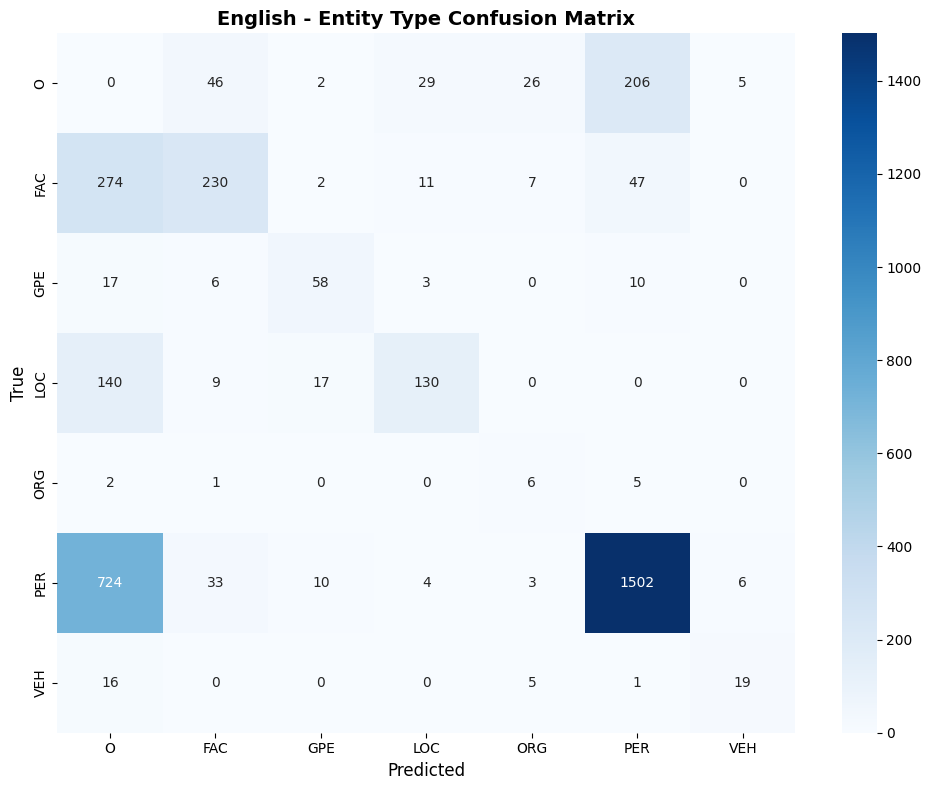


French:
  ✓ Saved to ../results/confusion_matrix_french.png


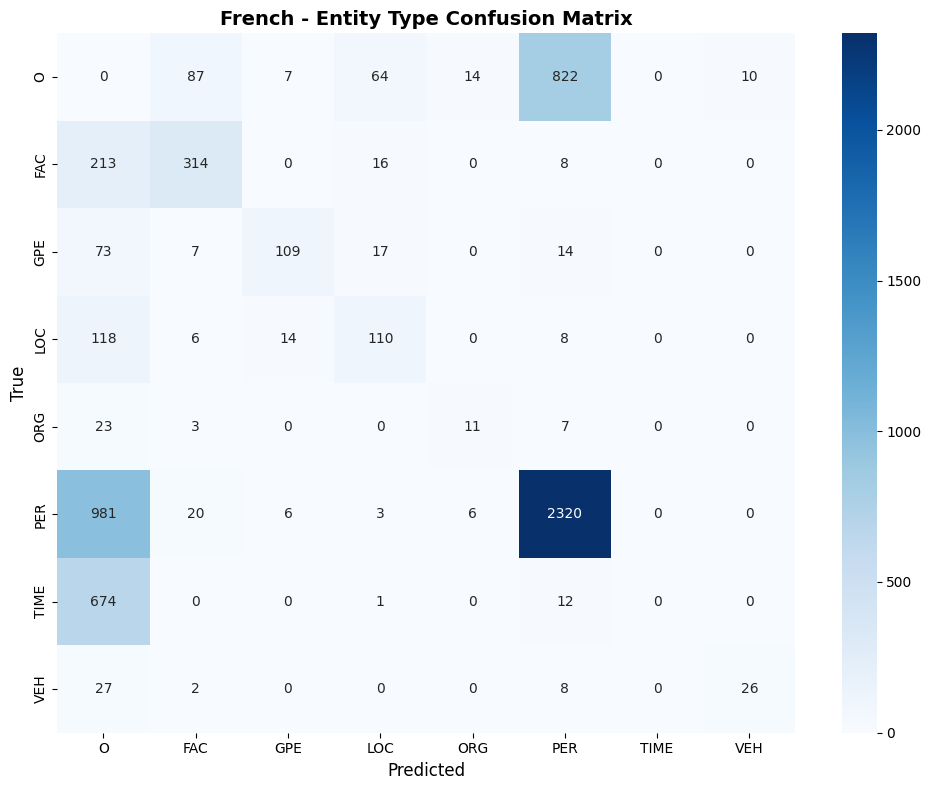


Italian:
  ✓ Saved to ../results/confusion_matrix_italian.png


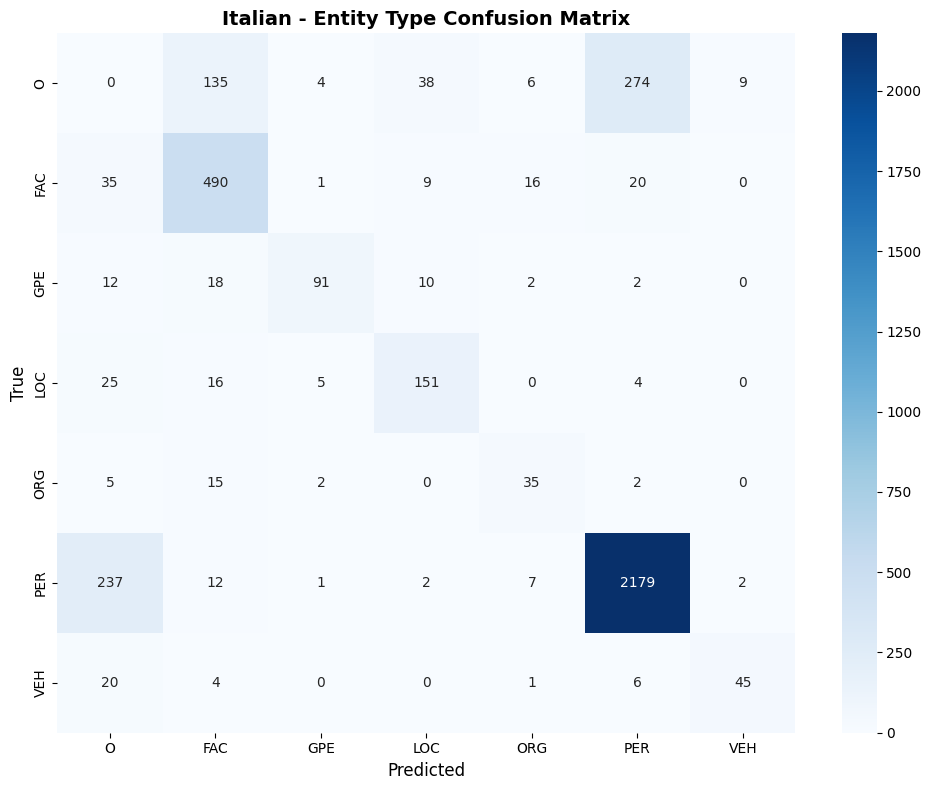

In [11]:
# Create confusion matrices for entity types (ignoring O tags for clarity)
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_entity_confusion_matrix(true_labels: List[List[str]], pred_labels: List[List[str]], 
                                    language: str) -> plt.Figure:
    """
    Create a confusion matrix for entity types (B-tags only, simplified view).
    """
    # Flatten and extract entity types (convert B-X and I-X to just X, keep O)
    true_flat = []
    pred_flat = []
    
    for true_seq, pred_seq in zip(true_labels, pred_labels):
        for true_label, pred_label in zip(true_seq, pred_seq):
            # Extract entity type
            true_type = true_label[2:] if true_label != 'O' else 'O'
            pred_type = pred_label[2:] if pred_label != 'O' else 'O'
            true_flat.append(true_type)
            pred_flat.append(pred_type)
    
    # Get all entity types (excluding O for cleaner visualization)
    all_types = sorted(set(true_flat + pred_flat))
    entity_types_only = [t for t in all_types if t != 'O']
    
    # Create confusion matrix for entities only
    entity_true = []
    entity_pred = []
    for t, p in zip(true_flat, pred_flat):
        if t != 'O' or p != 'O':  # Include if either is an entity
            entity_true.append(t)
            entity_pred.append(p)
    
    labels = ['O'] + entity_types_only
    cm = confusion_matrix(entity_true, entity_pred, labels=labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'{language} - Entity Type Confusion Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig


# Create confusion matrices for each language
print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

for lang, data in predictions_by_lang.items():
    print(f"\n{lang}:")
    fig = create_entity_confusion_matrix(data['true'], data['pred'], lang)
    
    # Save figure
    save_path = RESULTS_PATH / f"confusion_matrix_{lang.lower()}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved to {save_path}")
    
    plt.show()
    plt.close()

In [12]:
# Detailed error analysis: extract and categorize errors

def extract_entities_from_sequence(tokens: List[str], labels: List[str]) -> List[Dict]:
    """
    Extract entities from a BIO-tagged sequence.
    Returns list of dicts with entity text, type, start/end indices.
    """
    entities = []
    i = 0
    while i < len(labels):
        if labels[i].startswith('B-'):
            entity_type = labels[i][2:]
            start_idx = i
            entity_tokens = [tokens[i]]
            
            j = i + 1
            while j < len(labels) and labels[j] == f'I-{entity_type}':
                entity_tokens.append(tokens[j])
                j += 1
            
            entities.append({
                'text': ' '.join(entity_tokens),
                'type': entity_type,
                'start': start_idx,
                'end': j,
                'length': j - start_idx
            })
            i = j
        else:
            i += 1
    
    return entities


def analyze_errors(dataset: List[Dict], true_labels: List[List[str]], 
                   pred_labels: List[List[str]], language: str) -> Dict:
    """
    Analyze prediction errors and categorize them.
    
    Returns dict with:
        - false_positives: entities predicted but not in ground truth
        - false_negatives: entities in ground truth but not predicted
        - type_errors: entities with correct span but wrong type
        - partial_matches: entities with overlapping but not exact spans
    """
    false_positives = []
    false_negatives = []
    type_errors = []
    
    for idx, (example, true_seq, pred_seq) in enumerate(zip(dataset, true_labels, pred_labels)):
        tokens = example['tokens']
        
        true_entities = extract_entities_from_sequence(tokens, true_seq)
        pred_entities = extract_entities_from_sequence(tokens, pred_seq)
        
        # Create sets for comparison
        true_spans = {(e['start'], e['end']): e for e in true_entities}
        pred_spans = {(e['start'], e['end']): e for e in pred_entities}
        
        # Find false positives (predicted but not true)
        for span, pred_ent in pred_spans.items():
            if span not in true_spans:
                # Get context
                ctx_start = max(0, span[0] - 3)
                ctx_end = min(len(tokens), span[1] + 3)
                context = tokens[ctx_start:ctx_end]
                
                false_positives.append({
                    'example_idx': idx,
                    'entity': pred_ent['text'],
                    'pred_type': pred_ent['type'],
                    'length': pred_ent['length'],
                    'context': ' '.join(context)
                })
            elif true_spans[span]['type'] != pred_ent['type']:
                # Same span, different type
                type_errors.append({
                    'example_idx': idx,
                    'entity': pred_ent['text'],
                    'true_type': true_spans[span]['type'],
                    'pred_type': pred_ent['type'],
                    'length': pred_ent['length'],
                    'context': ' '.join(tokens[max(0, span[0]-3):min(len(tokens), span[1]+3)])
                })
        
        # Find false negatives (true but not predicted)
        for span, true_ent in true_spans.items():
            if span not in pred_spans:
                ctx_start = max(0, span[0] - 3)
                ctx_end = min(len(tokens), span[1] + 3)
                context = tokens[ctx_start:ctx_end]
                
                false_negatives.append({
                    'example_idx': idx,
                    'entity': true_ent['text'],
                    'true_type': true_ent['type'],
                    'length': true_ent['length'],
                    'context': ' '.join(context)
                })
    
    return {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'type_errors': type_errors
    }


# Analyze errors for each language
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

error_analysis = {}

for lang, data in predictions_by_lang.items():
    errors = analyze_errors(data['dataset'], data['true'], data['pred'], lang)
    error_analysis[lang] = errors
    
    print(f"\n{lang.upper()}:")
    print(f"  False Positives: {len(errors['false_positives']):,}")
    print(f"  False Negatives: {len(errors['false_negatives']):,}")
    print(f"  Type Errors:     {len(errors['type_errors']):,}")


ERROR ANALYSIS

ENGLISH:
  False Positives: 601
  False Negatives: 679
  Type Errors:     32

FRENCH:
  False Positives: 1,275
  False Negatives: 1,212
  Type Errors:     6

ITALIAN:
  False Positives: 356
  False Negatives: 273
  Type Errors:     42


In [13]:
# Display sample errors for each language and error type

def display_error_samples(errors: Dict, language: str, n_samples: int = 5):
    """Display sample errors for inspection."""
    
    print(f"\n{'='*70}")
    print(f"{language.upper()} - ERROR EXAMPLES")
    print(f"{'='*70}")
    
    # False Positives
    print(f"\n--- FALSE POSITIVES (predicted but not in ground truth) ---")
    fp_by_type = defaultdict(list)
    for fp in errors['false_positives']:
        fp_by_type[fp['pred_type']].append(fp)
    
    for entity_type in sorted(fp_by_type.keys()):
        samples = fp_by_type[entity_type][:n_samples]
        print(f"\n  {entity_type} ({len(fp_by_type[entity_type])} total):")
        for s in samples:
            print(f"    • \"{s['entity']}\" (len={s['length']})")
            print(f"      Context: ...{s['context']}...")
    
    # False Negatives
    print(f"\n--- FALSE NEGATIVES (missed entities) ---")
    fn_by_type = defaultdict(list)
    for fn in errors['false_negatives']:
        fn_by_type[fn['true_type']].append(fn)
    
    for entity_type in sorted(fn_by_type.keys()):
        samples = fn_by_type[entity_type][:n_samples]
        print(f"\n  {entity_type} ({len(fn_by_type[entity_type])} total):")
        for s in samples:
            print(f"    • \"{s['entity']}\" (len={s['length']})")
            print(f"      Context: ...{s['context']}...")
    
    # Type Errors
    if errors['type_errors']:
        print(f"\n--- TYPE ERRORS (correct span, wrong type) ---")
        for err in errors['type_errors'][:n_samples * 2]:
            print(f"  • \"{err['entity']}\"")
            print(f"    True: {err['true_type']} → Predicted: {err['pred_type']}")
            print(f"    Context: ...{err['context']}...")


# Display error samples for each language
for lang in predictions_by_lang.keys():
    display_error_samples(error_analysis[lang], lang, n_samples=3)


ENGLISH - ERROR EXAMPLES

--- FALSE POSITIVES (predicted but not in ground truth) ---

  FAC (91 total):
    • "streets" (len=1)
      Context: ...mud in the streets as if the...
    • "street-corners" (len=1)
      Context: ...their foot-hold at street-corners , where tens...
    • "yards" (len=1)
      Context: ...out on the yards and hovering in...

  GPE (14 total):
    • "great ( and dirty ) city" (len=6)
      Context: ...pollutions of a great ( and dirty ) city ....
    • "nation" (len=1)
      Context: ...to whom a nation owes its birth...
    • "the" (len=1)
      Context: ...of gold to the country where they...

  LOC (77 total):
    • "earth" (len=1)
      Context: ...face of the earth , and it...
    • "the" (len=1)
      Context: .... Fog up the river , where...
    • "river" (len=1)
      Context: ...Fog up the river , where it...

  ORG (18 total):
    • "leaden-headed old corporation , Temple Bar" (len=6)
      Context: ...threshold of a leaden-headed old corporation ,

In [14]:
# Analyze error rates by entity length

def analyze_errors_by_length(dataset: List[Dict], true_labels: List[List[str]], 
                              pred_labels: List[List[str]]) -> pd.DataFrame:
    """
    Analyze how error rates vary with entity length.
    """
    length_stats = defaultdict(lambda: {'correct': 0, 'fp': 0, 'fn': 0, 'type_error': 0})
    
    for example, true_seq, pred_seq in zip(dataset, true_labels, pred_labels):
        tokens = example['tokens']
        
        true_entities = extract_entities_from_sequence(tokens, true_seq)
        pred_entities = extract_entities_from_sequence(tokens, pred_seq)
        
        true_spans = {(e['start'], e['end']): e for e in true_entities}
        pred_spans = {(e['start'], e['end']): e for e in pred_entities}
        
        # Check each true entity
        for span, true_ent in true_spans.items():
            length = true_ent['length']
            if span in pred_spans:
                if pred_spans[span]['type'] == true_ent['type']:
                    length_stats[length]['correct'] += 1
                else:
                    length_stats[length]['type_error'] += 1
            else:
                length_stats[length]['fn'] += 1
        
        # Check false positives
        for span, pred_ent in pred_spans.items():
            if span not in true_spans:
                length_stats[pred_ent['length']]['fp'] += 1
    
    # Convert to DataFrame
    rows = []
    for length in sorted(length_stats.keys()):
        stats = length_stats[length]
        total_true = stats['correct'] + stats['fn'] + stats['type_error']
        total_pred = stats['correct'] + stats['fp'] + stats['type_error']
        
        recall = stats['correct'] / total_true if total_true > 0 else 0
        precision = stats['correct'] / total_pred if total_pred > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        rows.append({
            'length': length,
            'correct': stats['correct'],
            'false_neg': stats['fn'],
            'false_pos': stats['fp'],
            'type_error': stats['type_error'],
            'total_true': total_true,
            'recall': round(recall, 3),
            'precision': round(precision, 3),
            'f1': round(f1, 3)
        })
    
    return pd.DataFrame(rows)


# Analyze and display error rates by entity length
print("\n" + "="*70)
print("ERROR RATES BY ENTITY LENGTH")
print("="*70)

length_analysis = {}

for lang, data in predictions_by_lang.items():
    df = analyze_errors_by_length(data['dataset'], data['true'], data['pred'])
    length_analysis[lang] = df
    
    print(f"\n{lang.upper()}:")
    print(df.to_string(index=False))


ERROR RATES BY ENTITY LENGTH

ENGLISH:
 length  correct  false_neg  false_pos  type_error  total_true  recall  precision    f1
      1      197         94        308          24         315   0.625      0.372 0.467
      2      209        284        120           8         501   0.417      0.620 0.499
      3       48        142         56           0         190   0.253      0.462 0.327
      4       14         50         54           0          64   0.219      0.206 0.212
      5        5         36         23           0          41   0.122      0.179 0.145
      6        3         22         14           0          25   0.120      0.176 0.143
      7        2         15          8           0          17   0.118      0.200 0.148
      8        0          8          7           0           8   0.000      0.000 0.000
      9        1          8          3           0           9   0.111      0.250 0.154
     10        0          7          3           0           7   0.000      0.00

✓ Saved F1 by entity length plot to ../results/f1_by_entity_length.png


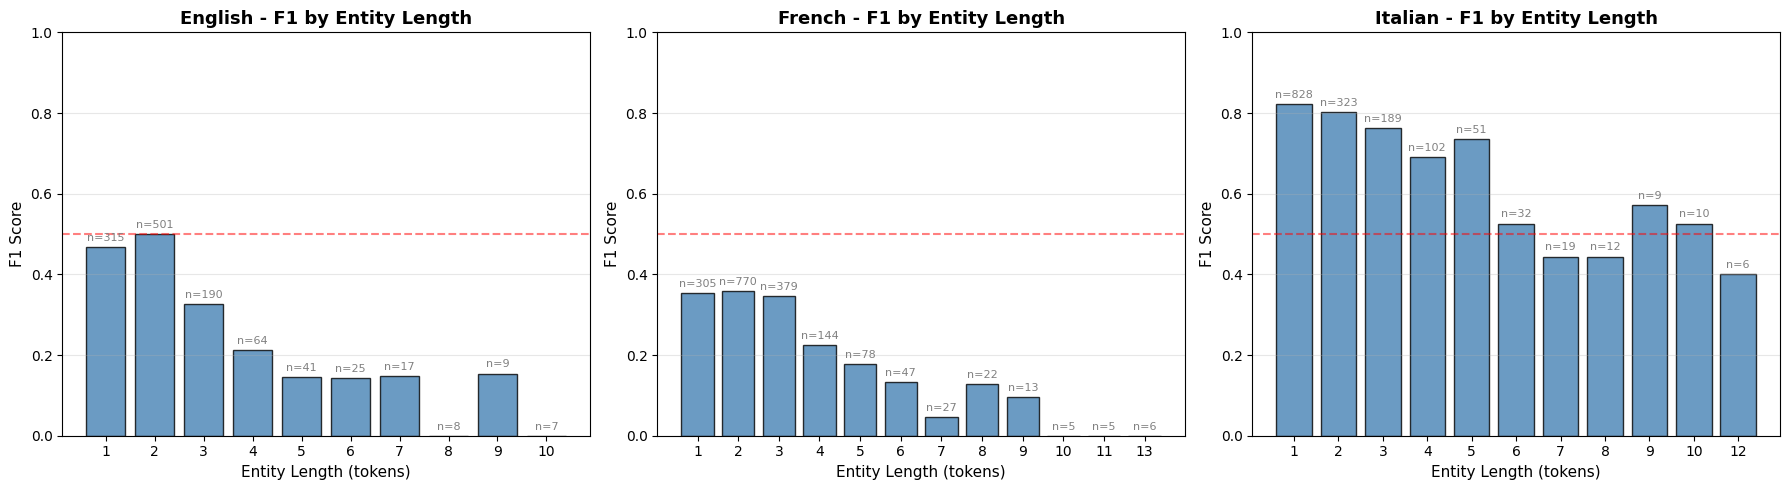

In [15]:
# Visualize F1 score by entity length for each language

fig, axes = plt.subplots(1, len(length_analysis), figsize=(6 * len(length_analysis), 5))
if len(length_analysis) == 1:
    axes = [axes]

for ax_idx, (lang, df) in enumerate(length_analysis.items()):
    # Filter to lengths with enough samples
    df_filtered = df[df['total_true'] >= 5].copy()
    
    if len(df_filtered) > 0:
        # Create bar chart
        bars = axes[ax_idx].bar(df_filtered['length'].astype(str), df_filtered['f1'], 
                                 color='steelblue', alpha=0.8, edgecolor='black')
        
        # Add sample count as text on bars
        for bar, count in zip(bars, df_filtered['total_true']):
            axes[ax_idx].annotate(f'n={count}', 
                                   xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                   xytext=(0, 3), textcoords="offset points",
                                   ha='center', va='bottom', fontsize=8, color='gray')
        
        axes[ax_idx].set_xlabel('Entity Length (tokens)', fontsize=11)
        axes[ax_idx].set_ylabel('F1 Score', fontsize=11)
        axes[ax_idx].set_title(f'{lang} - F1 by Entity Length', fontsize=13, fontweight='bold')
        axes[ax_idx].set_ylim(0, 1.0)
        axes[ax_idx].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='F1=0.5')
        axes[ax_idx].grid(axis='y', alpha=0.3)

plt.tight_layout()

save_path = RESULTS_PATH / "f1_by_entity_length.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved F1 by entity length plot to {save_path}")

plt.show()
plt.close()

In [16]:
# Export error analysis to CSV for further investigation

print("\n" + "="*70)
print("EXPORTING ERROR ANALYSIS")
print("="*70)

for lang, errors in error_analysis.items():
    # Export false positives
    if errors['false_positives']:
        fp_df = pd.DataFrame(errors['false_positives'])
        fp_path = RESULTS_PATH / f"errors_{lang.lower()}_false_positives.csv"
        fp_df.to_csv(fp_path, index=False)
        print(f"✓ {lang} false positives: {fp_path}")
    
    # Export false negatives
    if errors['false_negatives']:
        fn_df = pd.DataFrame(errors['false_negatives'])
        fn_path = RESULTS_PATH / f"errors_{lang.lower()}_false_negatives.csv"
        fn_df.to_csv(fn_path, index=False)
        print(f"✓ {lang} false negatives: {fn_path}")
    
    # Export type errors
    if errors['type_errors']:
        te_df = pd.DataFrame(errors['type_errors'])
        te_path = RESULTS_PATH / f"errors_{lang.lower()}_type_errors.csv"
        te_df.to_csv(te_path, index=False)
        print(f"✓ {lang} type errors: {te_path}")

# Export length analysis
for lang, df in length_analysis.items():
    length_path = RESULTS_PATH / f"error_rates_by_length_{lang.lower()}.csv"
    df.to_csv(length_path, index=False)
    print(f"✓ {lang} length analysis: {length_path}")

print("\n✓ All error analysis exported to CSV")


EXPORTING ERROR ANALYSIS
✓ English false positives: ../results/errors_english_false_positives.csv
✓ English false negatives: ../results/errors_english_false_negatives.csv
✓ English type errors: ../results/errors_english_type_errors.csv
✓ French false positives: ../results/errors_french_false_positives.csv
✓ French false negatives: ../results/errors_french_false_negatives.csv
✓ French type errors: ../results/errors_french_type_errors.csv
✓ Italian false positives: ../results/errors_italian_false_positives.csv
✓ Italian false negatives: ../results/errors_italian_false_negatives.csv
✓ Italian type errors: ../results/errors_italian_type_errors.csv
✓ English length analysis: ../results/error_rates_by_length_english.csv
✓ French length analysis: ../results/error_rates_by_length_french.csv
✓ Italian length analysis: ../results/error_rates_by_length_italian.csv

✓ All error analysis exported to CSV



CROSS-LANGUAGE SUMMARY

Language  Test Examples  True Entities  Pred Entities  Precision  Recall     F1  False Pos  False Neg  Type Errors
 English            693           1191           1113     0.4108  0.3935 0.4020        601        679           32
  French           1406           1815           1878     0.3078  0.3299 0.3184       1275       1212            6
 Italian            840           1589           1672     0.7296  0.8030 0.7645        356        273           42

✓ Summary saved to ../results/test_set_evaluation_summary.csv
✓ Saved F1 comparison plot to ../results/f1_comparison_by_language.png


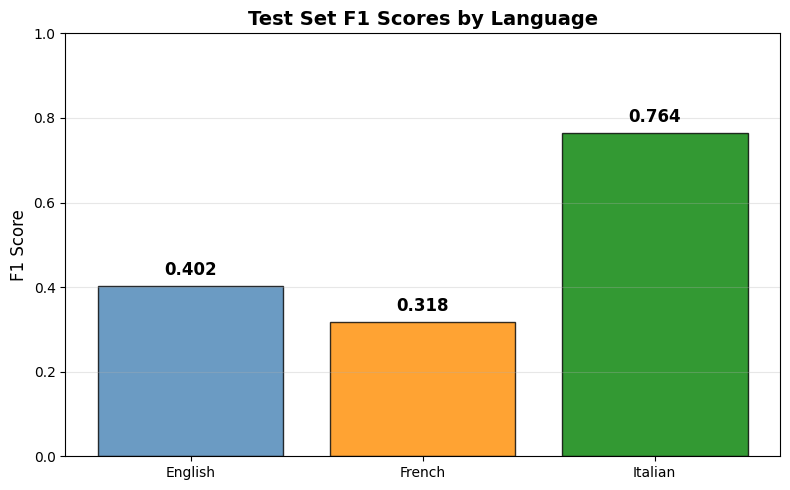


TEST SET ERROR ANALYSIS COMPLETE


In [17]:
# Summary comparison across languages

print("\n" + "="*70)
print("CROSS-LANGUAGE SUMMARY")
print("="*70)

summary_rows = []
for lang, data in predictions_by_lang.items():
    errors = error_analysis[lang]
    
    # Calculate metrics
    precision = precision_score(data['true'], data['pred'])
    recall = recall_score(data['true'], data['pred'])
    f1 = f1_score(data['true'], data['pred'])
    
    # Count total entities
    total_true = sum(len([l for l in seq if l.startswith('B-')]) for seq in data['true'])
    total_pred = sum(len([l for l in seq if l.startswith('B-')]) for seq in data['pred'])
    
    summary_rows.append({
        'Language': lang,
        'Test Examples': len(data['dataset']),
        'True Entities': total_true,
        'Pred Entities': total_pred,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'False Pos': len(errors['false_positives']),
        'False Neg': len(errors['false_negatives']),
        'Type Errors': len(errors['type_errors'])
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_path = RESULTS_PATH / "test_set_evaluation_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n✓ Summary saved to {summary_path}")

# Visualize F1 comparison
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(summary_df['Language'], summary_df['F1'], color=['steelblue', 'darkorange', 'green'], 
               alpha=0.8, edgecolor='black')

for bar, f1_val in zip(bars, summary_df['F1']):
    ax.annotate(f'{f1_val:.3f}', 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Test Set F1 Scores by Language', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_path = RESULTS_PATH / "f1_comparison_by_language.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved F1 comparison plot to {save_path}")
plt.show()
plt.close()

print("\n" + "="*70)
print("TEST SET ERROR ANALYSIS COMPLETE")
print("="*70)

---

## 4. Custom Text Predictions

Now that we've analyzed the model's performance on the test sets, let's see how it performs on new custom text examples.

### English Text Example

Test the model's performance with custom English literary text (passage from Charles Dickens' *A Christmas Carol*).

In [18]:
# English test passage - replace with your own text
english_text = "Although they had but that moment left the school behind them, they were now in the busy thoroughfares of a city, where shadowy passengers passed and re-passed; where shadowy carts and coaches battled for the way, and all the strife and tumult of a real city were. It was made plain enough, by the dressing of the shops, that here, too, it was Christmas-time again; but it was evening, and the streets were lighted up. The Ghost stopped at a certain warehouse door, and asked Scrooge if he knew it."

# Get predictions
english_predictions = ner_pipeline(english_text)

print("Detected entities:")
for entity in english_predictions:
    print(f"  - {entity['word']:25s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

# Display with color-coded tags
print("\nEnglish NER Results:")
display_ner_results(english_text, english_predictions, show_confidence=True)

Detected entities:
  - the school                → FAC    (confidence: 0.926)
  - busy thoroughfares of a   → FAC    (confidence: 0.765)
  - city                      → GPE    (confidence: 0.657)
  - shadowy passengers        → PER    (confidence: 0.992)
  - shadowy carts and         → VEH    (confidence: 0.812)
  - coaches                   → VEH    (confidence: 0.651)
  - real city                 → GPE    (confidence: 0.962)
  - shops                     → FAC    (confidence: 0.955)
  - streets                   → FAC    (confidence: 0.561)
  - The Ghost                 → PER    (confidence: 0.774)
  - certain warehouse         → FAC    (confidence: 0.815)
  - Scrooge                   → PER    (confidence: 0.912)

English NER Results:


### French Text Example

Test the model's performance with custom French literary text (passage from Guy de Maupassant's *Pierre et Jean*).

In [19]:
# French test passage - replace with your own text
french_text = "Les cabines roulantes, attelées d'un cheval, remontaient aussi; et sur les planches de la promenade, qui borde la plage d'un bout à l'autre, c'était maintenant une coulée continue, épaisse et lente, de foule élégante, formant deux courants contraires qui se coudoyaient et se mêlaient. Pierre, nerveux, exaspéré par ce frôlement, s'enfuit, s'enfonça dans la ville et s'arrêta pour déjeuner chez un simple marchand de vins, à l'entrée des champs."

# Get predictions
french_predictions = ner_pipeline(french_text)

print("Detected entities:")
for entity in french_predictions:
    print(f"  - {entity['word']:25s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

# Display with color-coded tags
print("\nFrench NER Results:")
display_ner_results(french_text, french_predictions, show_confidence=True)

Detected entities:
  - cabines roulantes         → VEH    (confidence: 0.692)
  - cheval                    → VEH    (confidence: 0.777)
  - plage                     → LOC    (confidence: 0.983)
  - foule élégante            → PER    (confidence: 0.977)
  - Pierre                    → PER    (confidence: 0.996)
  - la                        → LOC    (confidence: 0.433)
  - ville                     → GPE    (confidence: 0.946)
  - simple marchand de vins   → PER    (confidence: 0.991)
  - champs                    → LOC    (confidence: 0.928)

French NER Results:


### Italian Text Example

Test the model's performance with custom Italian literary text (passage from Carlo Collodi's *Pinocchio*).

In [20]:
# Italian test passage - replace with your own text
italian_text = "Detto fatto traversarono la città, e, usciti fuori delle mura, si fermarono in un campo solitario che, su per giù, somigliava a tutti gli altri campi. Pinocchio è derubato delle sue monete d'oro, e per gastigo si busca quattro mesi di prigione. Il burattino, ritornato in città, cominciò a contare i minuti a uno a uno: e quando gli parve che fosse l'ora, riprese subito la strada che menava al Campo dei miracoli."

# Get predictions
italian_predictions = ner_pipeline(italian_text)

print("Detected entities:")
for entity in italian_predictions:
    print(f"  - {entity['word']:25s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

# Display with color-coded tags
print("\nItalian NER Results:")
display_ner_results(italian_text, italian_predictions, show_confidence=True)

Detected entities:
  - città                     → GPE    (confidence: 0.981)
  - mura                      → FAC    (confidence: 0.935)
  - campo solitario           → FAC    (confidence: 0.974)
  - tutti gli altri campi     → FAC    (confidence: 0.953)
  - Pinocchio                 → PER    (confidence: 0.654)
  - città                     → GPE    (confidence: 0.984)
  - strada che menava         → FAC    (confidence: 0.821)
  - Campo dei miracoli        → FAC    (confidence: 0.963)

Italian NER Results:


## Attention Weight Visualization

**Why visualize attention?**
- Shows which tokens the model focuses on when making predictions
- Reveals if model attends to relevant context (nearby names, titles, etc.)
- Helps understand cross-lingual transfer mechanisms

**What to look for:**
- Strong attention to capitalized words (likely entities)
- Attention to title words ("Dr.", "President", etc.)
- Context dependencies (city names after "in", "from", etc.)

In [21]:
def visualize_attention(text: str, model, tokenizer, layer: int = -1, head: int = 0):
    """
    Visualize attention weights for a given text.
    
    Args:
        text: Input text
        model: Transformer model
        tokenizer: Tokenizer
        layer: Which layer to visualize (-1 = last layer)
        head: Which attention head to visualize
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt")
    
    # Get model outputs with attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Extract attention weights
    # Shape: (batch_size, num_heads, seq_len, seq_len)
    attention = outputs.attentions[layer][0, head].cpu().numpy()
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Plot attention heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(attention, cmap='viridis', aspect='auto')
    
    # Set ticks
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=9)
    ax.set_yticklabels(tokens, fontsize=9)
    
    ax.set_xlabel('Key Tokens (attending to)', fontsize=11)
    ax.set_ylabel('Query Tokens (attending from)', fontsize=11)
    ax.set_title(f'Attention Weights (Layer {layer}, Head {head})\n"{text}"', 
                fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=10)
    
    plt.tight_layout()
    return fig


print("✓ Attention visualization function defined")

✓ Attention visualization function defined



ATTENTION WEIGHT VISUALIZATIONS

Visualizing: English
Text: Although they had but that moment left the school behind them, they were now in the busy thoroughfar...
✓ Saved to ../results/attention_english.png


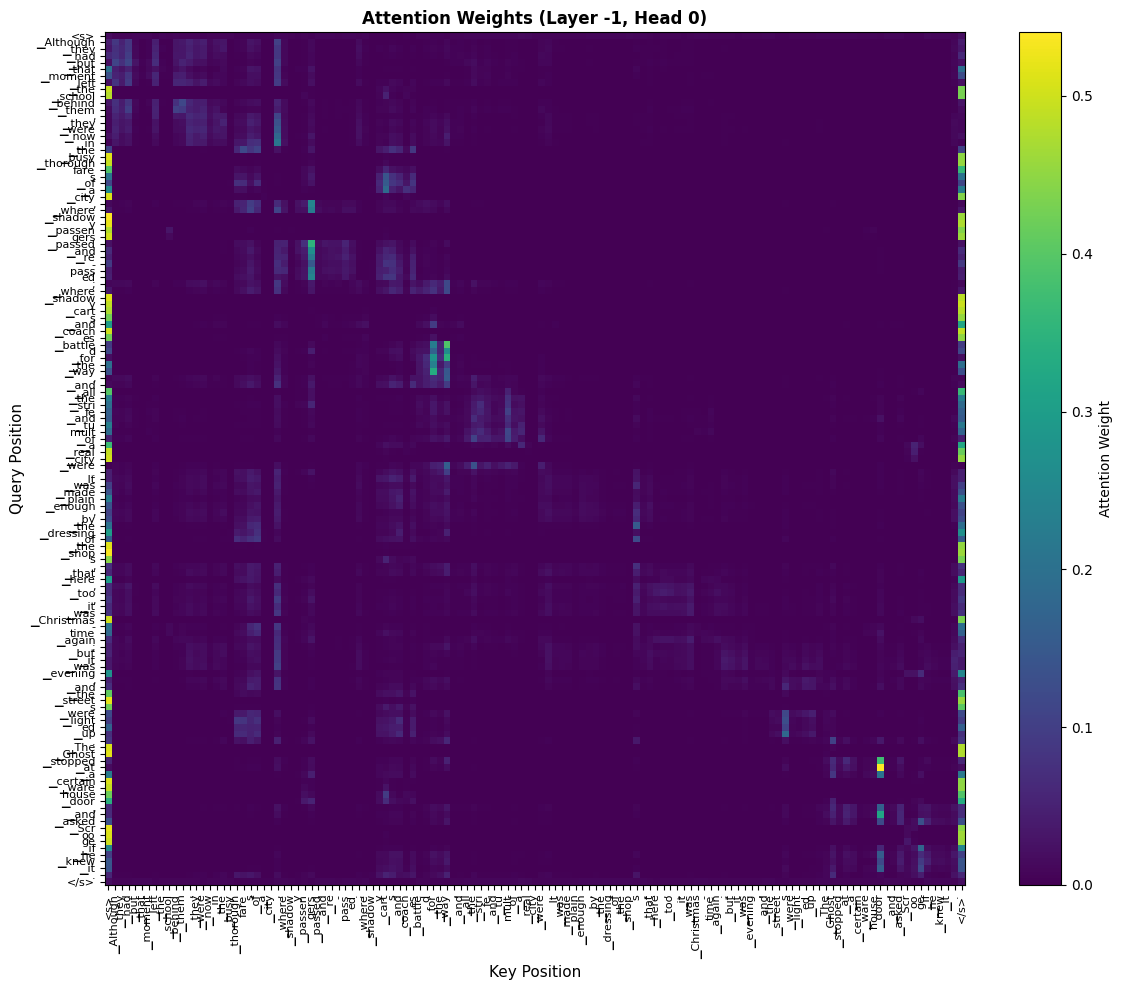


Visualizing: French
Text: Les cabines roulantes, attelées d'un cheval, remontaient aussi; et sur les planches de la promenade,...
✓ Saved to ../results/attention_french.png


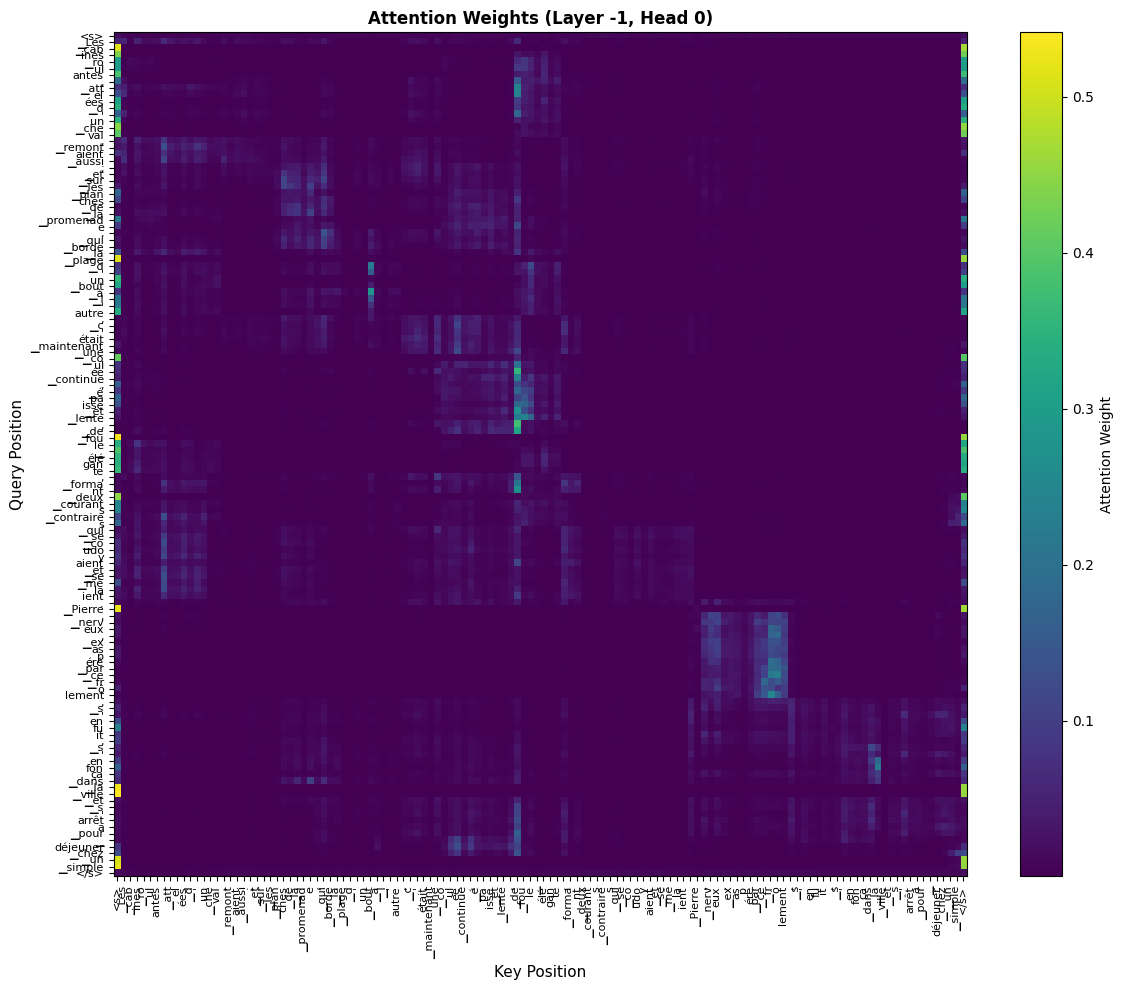


Visualizing: Italian
Text: Detto fatto traversarono la città, e, usciti fuori delle mura, si fermarono in un campo solitario ch...
✓ Saved to ../results/attention_italian.png


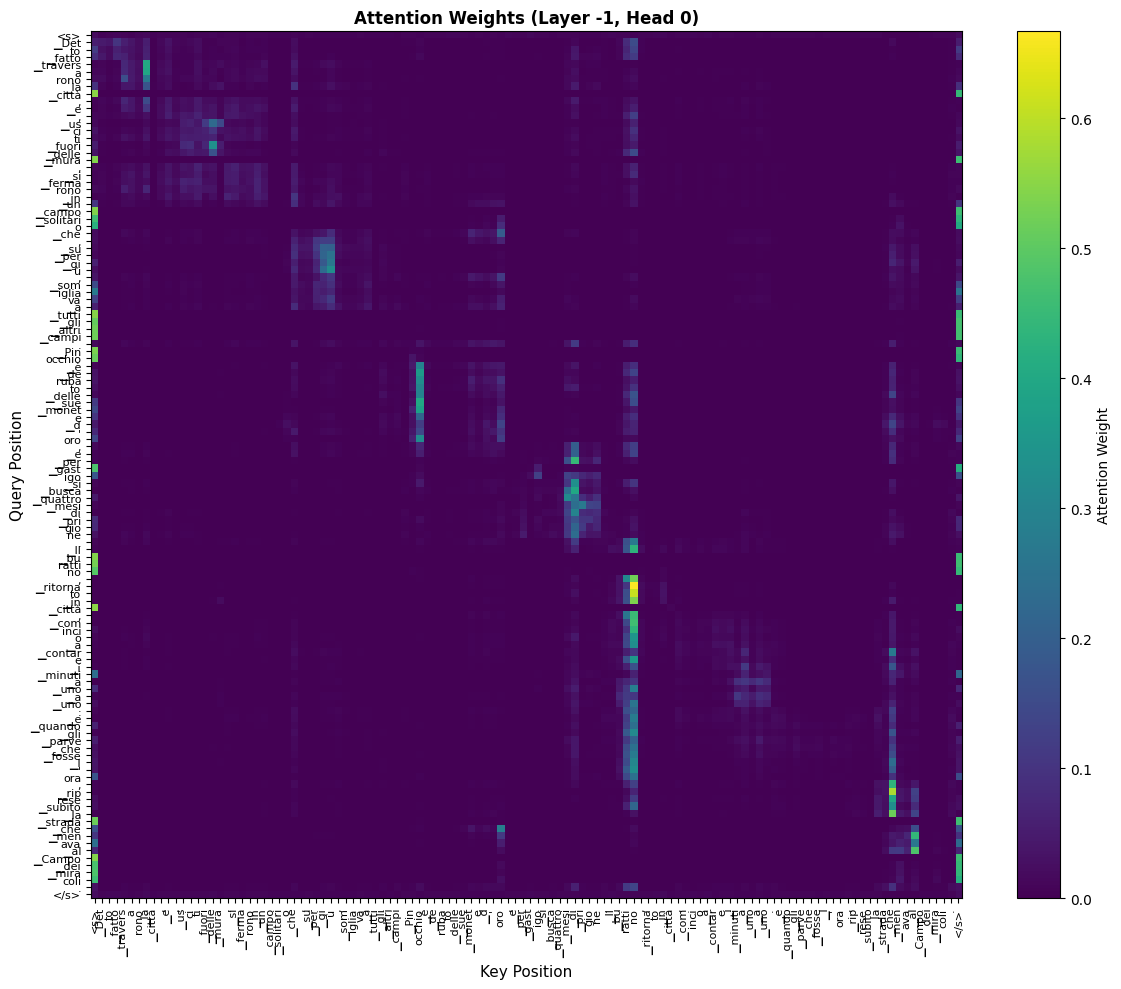


✓ All attention visualizations complete


In [23]:
# Visualize attention for the example sentences used above
example_sentences = [
    ("English", english_text),
    ("French", french_text),
    ("Italian", italian_text)
]

print("\n" + "="*60)
print("ATTENTION WEIGHT VISUALIZATIONS")
print("="*60)

for lang, text in example_sentences:
    print(f"\nVisualizing: {lang}")
    print(f"Text: {text[:100]}...")  # Show first 100 chars
    
    fig = visualize_attention(text, model, tokenizer, layer=-1, head=0)
    
    # Save figure
    filename = f"attention_{lang.lower()}.png"
    fig.savefig(RESULTS_PATH / filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved to {RESULTS_PATH / filename}")
    
    plt.show()
    plt.close()

print("\n✓ All attention visualizations complete")

In [22]:
def visualize_attention(text, model, tokenizer, layer=-1, head=0):
      """
      Visualize attention weights for a single text example.

      Args:
          text: Input text string
          model: Trained XLM-RoBERTa model
          tokenizer: Tokenizer
          layer: Which layer to visualize (-1 for last layer)
          head: Which attention head to visualize
      """
      # Tokenize input
      inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

      # Get the device the model is on
      device = next(model.parameters()).device

      # Move inputs to the same device as the model
      inputs = {k: v.to(device) for k, v in inputs.items()}

      # Get model outputs with attention weights
      with torch.no_grad():
          outputs = model(**inputs, output_attentions=True)

      # Extract attention weights
      # Shape: (batch_size, num_heads, seq_len, seq_len)
      attention = outputs.attentions[layer][0, head].cpu().numpy()

      # Get tokens for visualization
      tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu())

      # Create visualization
      fig, ax = plt.subplots(figsize=(12, 10))

      # Plot heatmap
      im = ax.imshow(attention, cmap='viridis', aspect='auto')

      # Set ticks and labels
      ax.set_xticks(range(len(tokens)))
      ax.set_yticks(range(len(tokens)))
      ax.set_xticklabels(tokens, rotation=90, fontsize=8)
      ax.set_yticklabels(tokens, fontsize=8)

      # Add colorbar
      plt.colorbar(im, ax=ax, label='Attention Weight')

      # Labels
      ax.set_xlabel('Key Position', fontsize=11)
      ax.set_ylabel('Query Position', fontsize=11)
      ax.set_title(f'Attention Weights (Layer {layer}, Head {head})',
                   fontsize=12, fontweight='bold')

      plt.tight_layout()
      return fig